# Object Detection

Here, I will show how to detect vehicles using `OpenCV`

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import warnings
import glob

%matplotlib inline

In [157]:
def plot_image(image, **kwargs):
    shape = image.shape
    assert len(shape) in [2, 3], "Wrong shape: {}".format(shape)
    
    if len(shape) == 2:
        H, W = shape
        C = 1
    elif len(shape) == 3:
        H, W, C = shape
    
    plt.figure(figsize=(10, 5))
    
    if C == 1:
        if "cmap" not in kwargs:
            plt.imshow(image, cmap="gray", **kwargs)
        else:
            plt.imshow(image, **kwargs)
    else:
        plt.imshow(image, **kwargs)

## Manual Detection

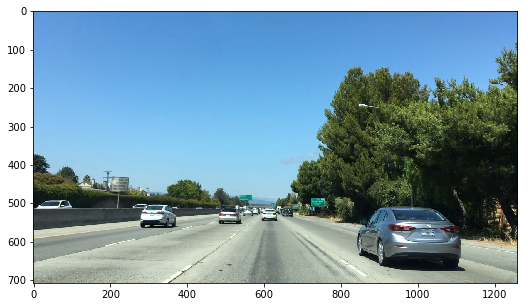

In [3]:
image = cv2.imread("./assets/bbox-example-image.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plot_image(image)

In [4]:
def draw_boxes(image, bboxes, color=(0, 0, 255), thickness=6, **kwargs):
    """Returns an image with bounding boxes drawn
    
    Parameters
    ----------
    image : 3-D array, shape (H, W, C)
    bboxes : list
        
        We need two points to draw a single bounding box
    
        [(point_A, point_B), (point_A, point_B), ...]
        where point_A = (x, y) tuple
        
    color : tuple (R, G, B)
    thickness : int
    
    Returns
    ----------
    image : 3-D array, same shape as image
    """
    
    image = np.copy(image)
    
    for point_A, point_B in bboxes:
        image = cv2.rectangle(image, point_A, point_B, color, thickness=thickness, **kwargs)
    
    return image    

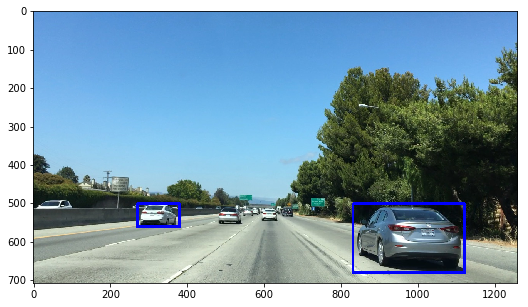

In [5]:
bboxes = [((830, 500), (1120, 680)),
          ((270, 560), (380, 500))]
new_image = draw_boxes(image, bboxes)

plot_image(new_image)

## Template Matching
- `cv2.matchTemplate`
- `cv2.minMaxLoc`

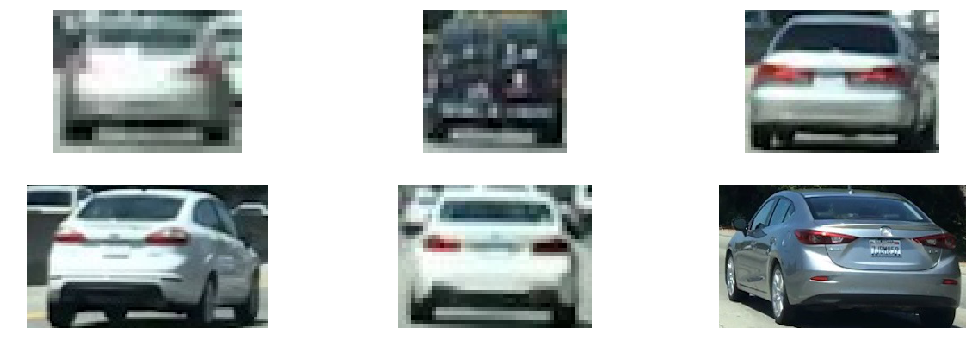

In [6]:
import glob
import matplotlib.image as mpimg

image = mpimg.imread('./assets/bbox-example-image.jpg')
templist = glob.glob("./assets/cutouts/cutout*.jpg")

# template plot
plt.figure(figsize=(15, 5))
for idx, temp_path in enumerate(templist):
    plt.subplot(2, 3, idx + 1)
    temp_image = mpimg.imread(temp_path)
    plt.imshow(temp_image)
    plt.axis("off")
plt.tight_layout()
plt.show();

In [7]:
def find_template_matches(image, templates, method=cv2.TM_SQDIFF_NORMED):
    """Returns bbox location
    
    Parameters
    ----------
    image : 3-D array (H, W, C)
    templates : list
        Each element is a string path to an image 
        
    Returns
    ----------
    bbox : list
        [(left_top, bottom_right), ...]
        left_top = (x, y)
        
    See also
    ----------
    .. [1] http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_template_matching/py_template_matching.html
    """
    
    bbox = []
    
    for template in templates:
        temp_img = mpimg.imread(template)        
        H, W, C = temp_img.shape
        
        res = cv2.matchTemplate(image, temp_img, method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
            
        bottom_right = (top_left[0] + W, top_left[1] + H)
        
        bbox.append((top_left, bottom_right))
        
    return bbox

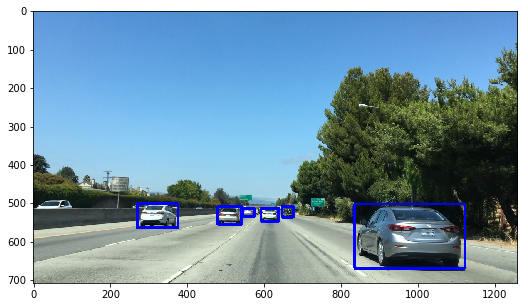

In [8]:
bboxes = find_template_matches(image, templist, cv2.TM_CCOEFF_NORMED)
new_image = draw_boxes(image, bboxes)
plot_image(new_image)

## Detection using Histogram

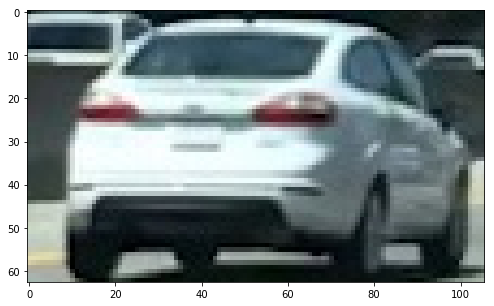

In [9]:
image = mpimg.imread("./assets/cutouts/cutout1.jpg")
plot_image(image)

In [10]:
def RGB_hist(image, n_bins=32, bin_range=(0, 256)):
    """Returns a RGB histogram"""
    
    R_hist = np.histogram(image[..., 0], bins=n_bins, range=bin_range)
    G_hist = np.histogram(image[..., 1], bins=n_bins, range=bin_range)
    B_hist = np.histogram(image[..., 2], bins=n_bins, range=bin_range)
    
    bin_centers = R_hist[1]    
    bin_centers = (bin_centers[1:] + bin_centers[:-1]) / 2    
    
    return R_hist[0], G_hist[0], B_hist[0], bin_centers

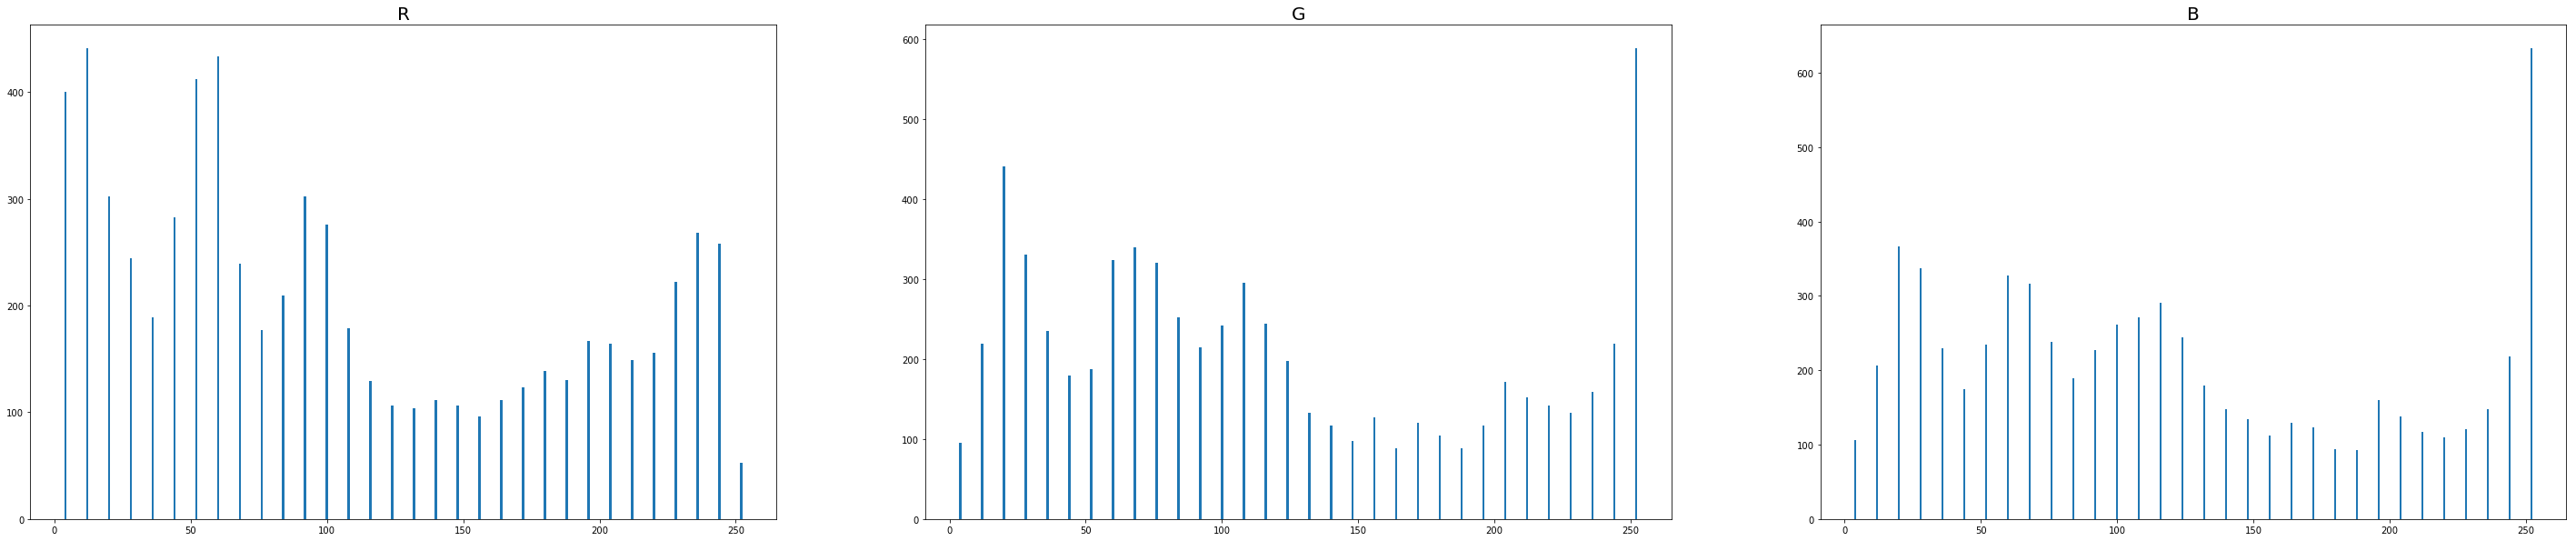

In [11]:
R_hist, G_hist, B_hist, bin_centers = RGB_hist(image)

def plot_tmp(idx, center, hist, title=None):
    plt.subplot(1, 3, idx)
    plt.bar(center, hist)
    if title:
        plt.title(title, fontsize=20)

plt.figure(figsize=(50, 10))
plot_tmp(1, bin_centers, R_hist, "R")
plot_tmp(2, bin_centers, G_hist, "G")
plot_tmp(3, bin_centers, B_hist, "B")

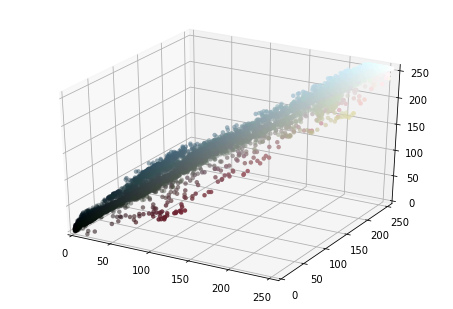

In [12]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3D(image):
    fig = plt.figure()
    ax = Axes3D(fig)

    ax.set_xlim(0, 256)
    ax.set_ylim(0, 256)
    ax.set_zlim(0, 256)

    R = image[..., 0].ravel()
    G = image[..., 1].ravel()
    B = image[..., 2].ravel()

    ax.scatter(R, G, B, 
               edgecolors='none',
               c=image.reshape((-1, 3)) / 255)


plot_3D(image)

## HOG

<img src="assets/hog-visualization.jpg" width="50%" />

In [13]:
from skimage.feature import hog

In [14]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """Returns a HOG features and image

    Parameters
    ----------
    img : (H, W) 2-D array
    orient : int
        Number of orientation bins

    pix_per_cell : tuple (int, int)
        Size of a cell (in pixel)

    cell_per_block : tuple (int, int)
        Number of cells in each block

    Returns
    ----------
    features : (D, ) 1-D array
    hog_image : (H, W) 2-D array
    """
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img,
                                  orient,
                                  pix_per_cell,
                                  cell_per_block,
                                  block_norm='L2-Hys', # Block-normalization method
                                  transform_sqrt=True, # Power-Law Compression
                                  visualise=vis,
                                  feature_vector=feature_vec)
        return features, hog_image
    else:
        # Use skimage.hog() to get features only
        features = hog(img,
                       orient,
                       pix_per_cell,
                       cell_per_block,
                       block_norm='L2-Hys',
                       transform_sqrt=True,
                       visualise=vis,
                       feature_vector=feature_vec)
        return features

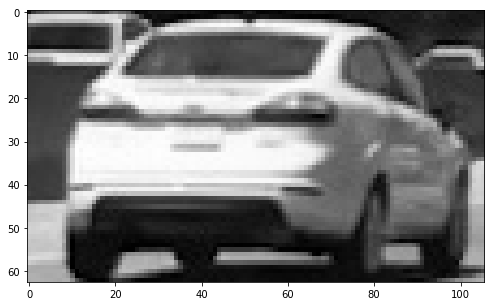

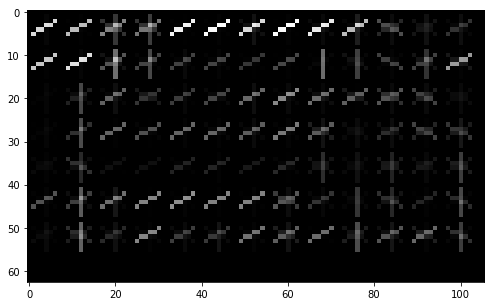

In [15]:
BW_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
features, HOG_image = get_hog_features(BW_image, 3, (8, 8), (2, 2), vis=True)

plot_image(BW_image)
plot_image(HOG_image)

## Sliding windows

In [16]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """Returns sliding windows positions

    Parameters
    ----------
    img : 3-D array (H, W, C)

    x_start_stop : list (int, int)
        Width range of sliding window
        None for the image width or 0

    y_start_stop : list (int, int)
        Height range of sliding window
        None for the image height or 0

    xy_window : tuple (int, int)
        (filter_width, filter_height)

    xy_overlap : tuple (float, float)
        How much overlapping when sliding windows
        (width_overlap, height_overlap)

    Returns
    ----------
    windows : list

        [(left_top_coord, right_bottom_coord), ...]
        = [((x, y), (x2, y2)), ((x, y), (x2, y2)), ...]


    Notes
    ----------

    xy_window : (filter_W, filter_H)
    W_stride =  filter_W * xy_overlap[0]

    how many iteration = (W or H - F - 2 * Pad) / S + 1

    for i in H iteration
        for j in W iteration
            left_top = (W_stride * j, H_stride * i)
            right_bottom = (left_top[0] + F_W, left_top[1] + F_H)    
    """
    
    def get_strides(xy_window, xy_overlap):
        """Returns W_stride, H_stride"""
        
        W_stride = xy_window[0] * xy_overlap[0]
        H_stride = xy_window[1] * xy_overlap[1]

        return int(W_stride), int(H_stride)

    def get_image_range(image, x_start_stop, y_start_stop):
        """Returns W_range, H_range"""

        def get_one_side_range(MAX_SIZE, start_stop):
            range_list = []
            range_list = [start_stop[0], start_stop[1]]

            if range_list[0] is None:
                range_list[0] = 0

            if range_list[1] is None:
                range_list[1] = MAX_SIZE

            return range_list

        shape = image.shape

        if len(shape) == 2:
            H, W = shape
            C = 1

        elif len(shape) == 3:
            H, W, C = shape

        W_range = get_one_side_range(W, x_start_stop)
        H_range = get_one_side_range(H, y_start_stop)

        return W_range, H_range

    def get_iterations(image, x_start_stop, y_start_stop, xy_window, xy_overlap):
        """Returns the number of iterations for height and width
        
        H_new = (H_old - FILTER_HEIGHT) / STRIDE_H + 1
        
        Returns
        ----------
        W_iter : int
        H_iter : int
        """

        W_range, H_range = get_image_range(image, x_start_stop, y_start_stop)
        
        H = H_range[1] - H_range[0]
        W = W_range[1] - W_range[0]
        
        filter_W, filter_H = xy_window
        stride_W, stride_H = get_strides(xy_window, xy_overlap)
        
        H_iter = (H - filter_H) / stride_H + 1
        W_iter = (W - filter_W) / stride_W + 1
        
        return int(W_iter), int(H_iter)
        
    window_list = []
    W_iter, H_iter = get_iterations(image, x_start_stop, y_start_stop, xy_window, xy_overlap)
    W_stride, H_stride = get_strides(xy_window, xy_overlap)
    W_filter, H_filter = xy_window
    W_range, H_range = get_image_range(image, x_start_stop, y_start_stop)
    for h in range(H_iter):
        for w in range(W_iter):
            left_top = (W_range[0] + W_stride * w, H_range[0] + H_stride * h)
            right_bottom = (left_top[0] + W_filter, left_top[1] + H_filter)
            
            window = (left_top, right_bottom)
            window_list.append(window)
            
    return window_list

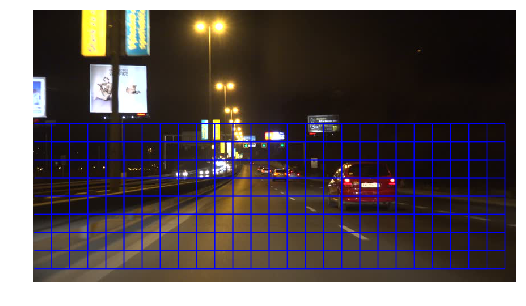

In [17]:
image = plt.imread("./assets/LA_night_test.jpg")
H, W, C = image.shape
windows = slide_window(image, x_start_stop=[0, W], y_start_stop=[200, H],
                       xy_window=(64, 64), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(image, windows, color=(0, 0, 255), thickness=1, lineType=cv2.LINE_AA)
plt.figure(figsize=(30, 10))
plot_image(window_img)
plt.axis('off');

## Piepline
Let's make a single window search
What can be used as an input for a classifier
- Color Space
- Resize and Ravel raw features
- histogram features
- hog features

In [18]:
def convert_color_space(image, color_space="RGB"):
    """Returns an image in given color space"""
    
    if color_space == "RGB":
        return np.copy(image)
    elif color_space == "HSV":
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif color_space == "LUV":
        return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif color_space == "HLS":
        return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif color_space == "YUV":
        return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif color_space == "YCrCb":
        return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        warnings.warn("{} space is not supported".format(color_space))
        return np.copy(image)
    

def get_bin_spatial_features(image, size=(32, 32)):
    """Resizes the image and flatten using ravel"""
    return cv2.resize(image, size).ravel()


def get_histogram_features(image, bins=32, bin_range=(0, 256)):
    """Returns a histogram features out of the image"""
    assert len(image.shape) == 3, "{} is not 3-D".format(image.shape)    
    C = image.shape[-1]
    
    features = []
    
    for i in range(C):
        hist, bins = np.histogram(image[..., i], bins, range=bin_range)
        features.append(hist)
    
    return np.concatenate(features, axis=0)


def get_hog_features(image, orient, pix_per_cell, cells_per_block, vis=False, feature_vec=True, **kwargs):
    """Returns a HOG features and image

    Parameters
    ----------
    img : (H, W) 2-D array
    
    orient : int
        Number of orientation bins

    pix_per_cell : tuple (int, int) or int
        Size of a cell (in pixel)

    cells_per_block : tuple (int, int) or int
        Number of cells in each block

    vis : bool
        Returns an image
    
    feature_vec : bool
        Returns a feature vector
        
    Returns
    ----------
    features : (D, ) 1-D array
    hog_image : (H, W) 2-D array
    """
    
    shape = image.shape
    assert len(shape) == 2, "Input must be (H, W) shaped but {} was given".format(shape)
    
    if type(pix_per_cell) == int:
        pix_per_cell = (pix_per_cell,) * 2
    
    if type(cells_per_block) == int:
        cells_per_block = (cells_per_block,) * 2
    
    ret = hog(image, orient, pix_per_cell, cells_per_block, visualise=vis, feature_vector=feature_vec, block_norm='L2', **kwargs)
    
    return ret        

In [19]:
image = mpimg.imread("./assets/bbox-example-image.jpg")
# Test `convert_color_space`
output = convert_color_space(image, "HSV")
np.testing.assert_equal(output, cv2.cvtColor(image, cv2.COLOR_RGB2HSV))

# Test bin_spatial
output = get_bin_spatial_features(image, (32, 32))
np.testing.assert_equal(output, cv2.resize(image, (32, 32)).ravel())

# Test hist features
output = get_histogram_features(image, bins=32, bin_range=(0, 256))
np.testing.assert_equal(output.shape, (32 * 3, ))

In [20]:
def extract_feature(image,
                    color_space="RGB",
                    spatial_size=(32, 32),
                    hist_bins=32,
                    orient=9, pix_per_cell=8, cells_per_block=2, hog_channel=0,
                    spatial_feat=True, hist_feat=True, hog_feat=True):
    """Returns features from a single image
    
    Parameters
    ----------
    image : 3-D array (H, W, C)
    
    color_space : str {"RGB", "HSV", "LUV", "HLS", "YCrCb", "YUV"}
        (default: "RGB")
    
    spatial_size : tuple (int, int)
        Spatial size features (default: (32, 32))
    
    hist_bins : int
        Number of histogram bins
        
    orient : int
        Number of orientation bins (default: 9)
    
    pix_per_cell : int
        Number of pixels in one cell (default: 8)
        
    cells_per_block : int
        Number of cells per block (default: 2)
        That means one block is composed of 2 by 2 cells
        
    hog_channel : int or "ALL"
        Which channel to use
    
    spatial_feat : bool
        Returns spatial feature
        
    hist_feat : bool
        Returns histogram features
    
    hog_feat : bool
        Returns hog features
        
    Returns
    ----------
    features : 1-D array
        All features are concatenated as a single row
    """
    features = []    
    color_converted_image = convert_color_space(image, color_space)
    
    if spatial_feat:
        spatial_features = get_bin_spatial_features(image, spatial_size)
        features.append(spatial_features)
    
    if hist_feat:
        hist_features = get_histogram_features(image, hist_bins)
        features.append(hist_features)
        
    if hog_feat:
        H, W, C = image.shape
        
        if hog_channel == "ALL":
            hog_features = []
            
            for c in range(C):
                
                hog_feat = get_hog_features(image[..., c], orient, pix_per_cell, cells_per_block)
                hog_features.append(hog_feat)
                
            hog_features = np.concatenate(hog_features, axis=0)
            
        else:
            
            assert hog_channel < C, "Image dimenstion is not correct for a HOG: given {}".format(image.shape)
            hog_features = get_hog_features(image[..., hog_channel], orient, pix_per_cell, cells_per_block)
            
        
        features.append(hog_features)
        
    
    return np.concatenate(features, axis=0)

In [21]:
def extract_features(images_path,
                     color_space="RGB",
                     spatial_size=(32, 32),
                     hist_bins=32,
                     orient=9, pix_per_cell=8, cells_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    """Returns features from multiple images

    Parameters
    ----------
    images_path : list
        ["FilePath1.jpg", "FilePath2.jpg", ...]

    color_space : str {"RGB", "HSV", "LUV", "HLS", "YCrCb", "YUV"}
        (default: "RGB")

    spatial_size : tuple (int, int)
        Spatial size features (default: (32, 32))

    hist_bins : int
        Number of histogram bins

    orient : int
        Number of orientation bins (default: 9)

    pix_per_cell : int
        Number of pixels in one cell (default: 8)

    cells_per_block : int
        Number of cells per block (default: 2)
        That means one block is composed of 2 by 2 cells

    hog_channel : int or "ALL"
        Which channel to use

    spatial_feat : bool
        Returns spatial feature

    hist_feat : bool
        Returns histogram features

    hog_feat : bool
        Returns hog features

    Returns
    ----------
    features : 2-D array (N, D)
    """
    features = []

    for image_path in images_path:
        image = mpimg.imread(image_path)
        feat = extract_feature(image, color_space=color_space,
                               spatial_size=spatial_size,
                               hist_bins=hist_bins,
                               orient=orient, pix_per_cell=pix_per_cell, cells_per_block=cells_per_block, hog_channel=hog_channel,
                               spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

        features.append(feat)

    return np.vstack(features)

# Appliactions

## Prepare training datasets

In [22]:
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):

    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(
            img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # 4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        # 5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # 6) Predict using your classifier
        prediction = clf.predict(test_features)
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # 8) Return windows for positive detections
    return on_windows

In [23]:
def search_windows(image, windows, clf, scaler, **kwargs):
    """Returns a box where classifier predicts there is a car
    
    Parameters
    ----------
    image : 3-D array (H, W, C)
    windows : list
        [(left_top, bottom_right), ...]
    clf : sklearn.model
    scaler : sklearn.scaler
    **kwargs
        Keywords arguements for single_img_features
        
    Returns
    ----------
    bbox : list
    """
    def crop_partial_image(image, left_top, bottom_right):
        W_begin, H_begin = left_top
        W_end, H_end = bottom_right
        
        partial_image = image[H_begin:H_end, W_begin:W_end, :]
        
        return cv2.resize(partial_image, (64, 64))
    
    
    bbox = []
        
    for left_top, bottom_right in windows:

        partial_image = crop_partial_image(image, left_top, bottom_right)
        assert partial_image.shape == (64, 64, 3), "{} != (64, 64, 3)".format(partial_image.shape)
        
        features = extract_feature(partial_image, **kwargs)
        features = scaler.transform(features.reshape(1, -1))

        pred = clf.predict(features)

        if pred == 1:
            bbox.append((left_top, bottom_right))
                
    return bbox

In [24]:
def read_image_path():
    """Returns car/noncar image path
    
    Assume image are located in 
    
    - assets/vehicles/vehicles_smallset/cars{}/{}.jpeg
    - assets/vehicles/non-vehicles_smallset/notcars{}/{}.jpeg
    
    """
    BASE_DIR = "./assets/vehicles/"

    
    CAR_DIR = BASE_DIR + "vehicles_smallset/"
    NOT_CAR_DIR = BASE_DIR + "non-vehicles_smallset/"
    
    CARS = ["cars1", "cars2", "cars3"]
    NOT_CARS = ["notcars1", "notcars2", "notcars3"]
    
    car_list = []
    notcar_list = []
    
    for car in CARS:
        car_list += glob.glob(CAR_DIR + car + "/*.jpeg")
        
    for not_car in NOT_CARS:
        notcar_list += glob.glob(NOT_CAR_DIR + not_car + "/*.jpeg")
    
    return car_list, notcar_list    

In [25]:
car_list, notcar_list = read_image_path()

assert any("cars1" in filename for filename in car_list)
assert any("cars2" in filename for filename in car_list)
assert any("cars3" in filename for filename in car_list)

assert any("notcars1" in filename for filename in notcar_list)
assert any("notcars2" in filename for filename in notcar_list)
assert any("notcars3" in filename for filename in notcar_list)

In [26]:
car_features = extract_features(car_list)
notcar_features = extract_features(notcar_list)

In [27]:
assert car_features.shape[1] == notcar_features.shape[1]
assert car_features.shape[0] == len(car_list)
assert notcar_features.shape[0] == len(notcar_list)

In [28]:
X_train = np.concatenate((car_features, notcar_features), axis=0)

y_train = [1] * len(car_features) + [0] * len(notcar_features)
y_train = np.array(y_train)

assert X_train.shape[0] == y_train.shape[0]

print("X_train: {}, y_train: {}".format(X_train.shape, y_train.shape))

X_train: (2321, 4932), y_train: (2321,)


## Sklearn Classifiers

In [41]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [30]:
feature_params = {
    "color_space": "HSV",  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    "orient": 9,  # HOG orientations
    "pix_per_cell": 8,  # HOG pixels per cell
    "cells_per_block": 2,  # HOG cells per block
    "hog_channel": "ALL",  # Can be 0, 1, 2, or "ALL"
    "spatial_size": (16, 16),  # Spatial binning dimensions
    "hist_bins": 16,  # Number of histogram bins
    "spatial_feat": True,  # Spatial features on or off
    "hist_feat": True,  # Histogram features on or off
    "hog_feat": True,  # HOG features on or off
}
car_list, notcar_list = read_image_path()

In [31]:
car_features = extract_features(car_list, **feature_params)
notcar_features = extract_features(notcar_list, **feature_params)

In [32]:
X_train = np.concatenate((car_features, notcar_features), axis=0)

y_train = [1] * len(car_features) + [0] * len(notcar_features)
y_train = np.array(y_train)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.7)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [42]:
params = {
    "C": np.random.uniform(high=100, size=5),
    "kernel": ["rbf", "linear", "poly"],
    "gamma": np.random.uniform(low=0, high=1, size=5)
}
# clf = RandomizedSearchCV(SVC(), params, n_jobs=8)
clf = SVC()

In [46]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

array([1, 1, 0, ..., 0, 0, 1])

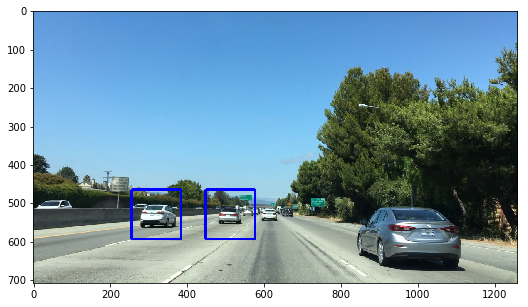

In [69]:
windows = slide_window(image, y_start_stop=[400, None], xy_window=(128, 128))
bbox = search_windows(image, windows, clf, scaler, **feature_params)

output = draw_boxes(image, bbox)
plot_image(output)

## Deep Learning Approach

In [235]:
import keras
import keras.metrics
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [308]:
def read_image(image_path):
    return mpimg.imread(image_path)

def path2array(image_path):
    array = [read_image(path) for path in image_path]
    return np.array(array)

def samplewise_normalization(image):
    N = K.shape(image)[0]

    _, H, W, C = np.shape(image)
    
    H = int(H)
    W = int(W)
    C = int(C)
    
    
    reshaped = K.reshape(image, (N, -1))
    reshaped = (reshaped - K.reshape(K.mean(reshaped, 1), (N, -1))) / K.reshape(K.std(reshaped, 1), (N, -1))

    return K.reshape(reshaped, (N, H, W, C))     

In [309]:
car_list, nocar_list = read_image_path()
car_list = path2array(car_list)
nocar_list = path2array(nocar_list)

X = np.concatenate((car_list, nocar_list), axis=0)
y = [1] * len(car_list) + [0] * len(nocar_list)
y = np.array(y)

assert car_list.shape[1] == nocar_list.shape[1]
assert X.shape[1:] == car_list.shape[1:]
assert X.shape[0] == len(car_list) + len(nocar_list)
assert X.shape[0] == y.shape[0]

In [310]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

N_train = X_train.shape[0]
N_test = X_test.shape[0]

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(1624, 64, 64, 3)
(697, 64, 64, 3)
(1624,)
(697,)


In [311]:
X = layers.Input(shape=(64, 64, 3), name="X")

In [349]:
def build_model(X, hidden_dims=[32, 64, 128]):
    net = X
    
    for h_dim in hidden_dims:
        net = layers.Conv2D(h_dim, (3,  3))(net)
        net = layers.BatchNormalization()(net)
        net = layers.Activation("relu")(net)
        net = layers.MaxPool2D()(net)
        
    net = layers.Conv2D(256, (6, 6))(net)
    net = layers.BatchNormalization()(net)
    net = layers.Activation("relu")(net)
    
    net = layers.Conv2D(2, (1, 1))(net)
    net = layers.Reshape((2, ))(net)
    net = layers.Activation("softmax")(net)
    
    return keras.models.Model(inputs=X, outputs=net)


model = build_model(X)
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization_86 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
activation_97 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_87 (Batc (None, 29, 29, 64)        256       
__________

In [391]:
train_gen = ImageDataGenerator(rotation_range=45,
                               width_shift_range=0.5,
                               height_shift_range=0.5,
                               shear_range=0.5,
                               zoom_range=0.5,
                               horizontal_flip=True)
test_gen = ImageDataGenerator()

train_gen = train_gen.flow(X_train, y_train)
test_gen = test_gen.flow(X_test, y_test)

callback = keras.callbacks.EarlyStopping(patience = 10)

In [392]:
model.fit_generator(train_gen, 
                    steps_per_epoch=N_train/32,
                    validation_data=test_gen,
                    validation_steps=N_test/32, 
                    callbacks=[callback],
                    epochs=100)

Epoch 1/100
51/50 [==============================] - 0s - loss: 0.0990 - acc: 0.9667 - val_loss: 0.0349 - val_acc: 0.9885
Epoch 2/100
51/50 [==============================] - 0s - loss: 0.1223 - acc: 0.9577 - val_loss: 0.1809 - val_acc: 0.9225
Epoch 3/100
51/50 [==============================] - 0s - loss: 0.0826 - acc: 0.9671 - val_loss: 0.0286 - val_acc: 0.9943
Epoch 4/100
51/50 [==============================] - 0s - loss: 0.0655 - acc: 0.9753 - val_loss: 0.0515 - val_acc: 0.9842
Epoch 5/100
51/50 [==============================] - 0s - loss: 0.0792 - acc: 0.9704 - val_loss: 0.0601 - val_acc: 0.9813
Epoch 6/100
51/50 [==============================] - 0s - loss: 0.0724 - acc: 0.9753 - val_loss: 0.0175 - val_acc: 0.9971
Epoch 7/100
51/50 [==============================] - 0s - loss: 0.0627 - acc: 0.9767 - val_loss: 0.0125 - val_acc: 0.9971
Epoch 8/100
51/50 [==============================] - 0s - loss: 0.0555 - acc: 0.9804 - val_loss: 0.0291 - val_acc: 0.9914
Epoch 9/100
51/50 [=====

In [393]:
def run_classify_on_windows(image, windows):
    
    def get_partial_window(image, left_top, right_bottom, FILTER_SIZE=(64, 64)):
        
        W_beg, H_beg = left_top
        W_end, H_end = right_bottom
        
        partial = image[H_beg:H_end, W_beg:W_end, :]
        
        return cv2.resize(partial, FILTER_SIZE)
        
    bbox = []
    
    for left_top, right_bottom in windows:
        partial_image = get_partial_window(image, left_top, right_bottom)
        partial_image = np.expand_dims(partial_image, 0)
                
        pred = model.predict(partial_image)
                        
        if pred[0][1] > 0.5:
            bbox.append((left_top, right_bottom))
            
    return bbox

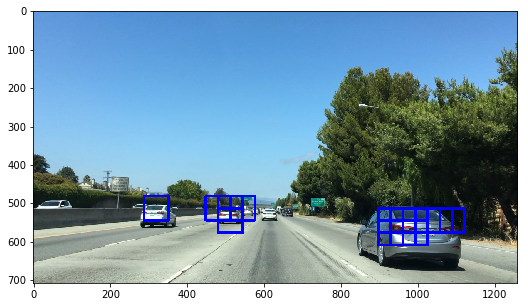

In [394]:
windows = slide_window(image, xy_window=(64, 64), xy_overlap=(0.5, 0.5))
bbox = run_classify_on_windows(image, windows)
output = draw_boxes(image, bbox)

plot_image(output)

## Heatmap (Dealing with false positives)

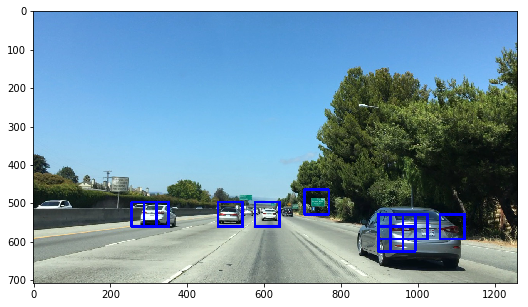

In [417]:
windows_size = ((64, 64), )
windows_final = []

for window in windows_size:
    windows = slide_window(image, xy_window=window, y_start_stop=[400, None])
    bbox = run_classify_on_windows(image, windows)
    windows_final += bbox
    
output = draw_boxes(image, windows_final)

plot_image(output)

In [418]:
def add_heatmap(heat_map, bbox):
    
    for left_top, right_bottom in bbox:
        
        W_beg, H_beg = left_top
        W_end, H_end = right_bottom
        
        heat_map[H_beg:H_end, W_beg:W_end] += 1
    
    return heat_map

def apply_threshold(heat_map, threshold):
    heat_map = heat_map
    heat_map[heat_map < threshold] = 0
    return heat_map

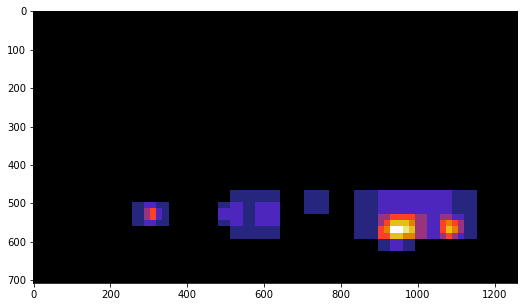

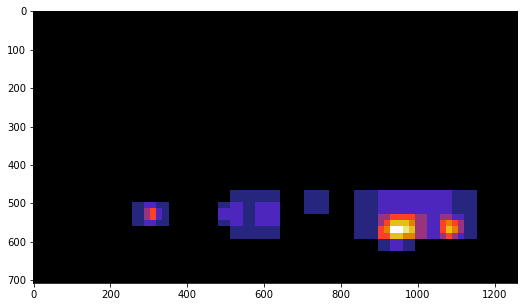

In [422]:
H, W, C = image.shape

heat_map = np.zeros((H, W))
heat_map = add_heatmap(heat_map, windows_final)

plot_image(heat_map, cmap="CMRmap")

heat_map = apply_threshold(heat_map, 0)
plot_image(heat_map, cmap="CMRmap")

In [423]:
from scipy.ndimage.measurements import label
labels = label(heat_map, )

4 cars are found


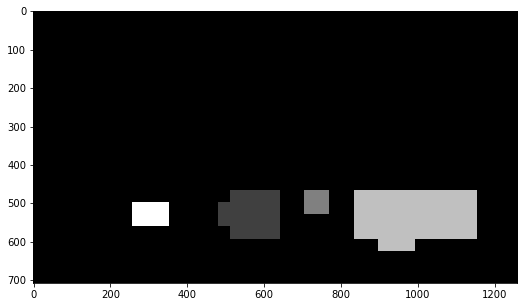

In [424]:
print(labels[1], "cars are found")
plot_image(labels[0])

In [413]:
def draw_labeld(image, labels):
    bboxes = []
    n_classes = labels[1]
    
    for i in range(n_classes):
        nonzero = np.nonzero(labels[0] == (i + 1))
        
        nonzero_row = nonzero[0]
        nonzero_col = nonzero[1]
        
        left_top = (np.min(nonzero_col), np.min(nonzero_row))
        right_bottom = (np.max(nonzero_col), np.max(nonzero_row))
        
        bboxes.append((left_top, right_bottom))
    
    return bboxes

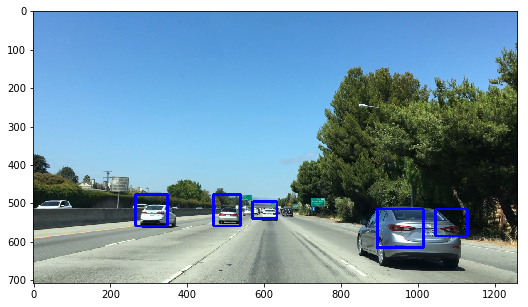

In [435]:
H, W, C = image.shape

windows_size = ((64, 64), (32, 32))
windows_final = []

for window in windows_size:
    windows = slide_window(image, xy_window=window, y_start_stop=[400, None], xy_overlap=(0.3, 0.3))
    bbox = run_classify_on_windows(image, windows)
    windows_final += bbox
    
heat_map = np.zeros((H, W))
heat_map = add_heatmap(heat_map, windows_final)
heat_map = apply_threshold(heat_map, 2)

labels = label(heat_map, )

bboxes = draw_labeld(image, labels)
output = draw_boxes(image, bboxes)
plot_image(output)